# Toy Model - Gut-Brain Axis in Reinforcement Behavior

We start with defining the Behavior/Action Module.

Essentially, Behavior -> Gut Bacteria -> Reinforcement in Brain -> Behavior.

Let's define one object for each of the compartments here - Behavior, Gut, Brain.

## Behavior

This module computes a State Transition Matrix upon instantiation.
When you create a Behavior object, it will take some time because the STM takes time to compute.
But it enables fast running of the actual simulation because the pre-computed matrix is directly
used.



## Gut

__Attributes:__

- agentArray[] OR populationSizeArray[]
- output                      #eg: dopamine

__Methods:__

- updateAgents() OR updatePopulations()
- getOutput()



## Brain

__Attributes:__

- alpha
- gamma
- epsilon
- qTable
- currentActionIndex


__Methods:__

- explore()
- exploit()
- computeReward(Gut.output)
- learn() 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import random
import time

In [7]:
# random.seed(1)

# class Bacteria():
    
    
    
class Behavior():    
    def __init__(self,randomState = True,**kwargs):
        
        """
        CLASS BEHAVIOR
        This is where actions are implemented to change the state of the system.
        
        
        INPUTS:
        
        initState -> The initial state of the system.
                     Under current implementation an n-tuple of floats.
                     Float values must be b/w 0.0 and 1.0 in intervals of 0.1.
                     eg: (1.0, 0.2, 1.0) 
                   
                   
        ATTRIBUTES:
 
                        
        stateSet ->     A list of all possible states, ie a list of n-tuples.
        
        actionSet ->    A list of actions. 
                        The format is dependant on how you define an action.
                        But as a general rule, use the index and not the values when interacting
                        with the RL module.
                        Use the values only in the applyAction() method.
                        
        output ->       Binary triplet. Sampled independantly, where each stateSet value is
                        interpreted as a probability of the corresponding nutrient output
                        being 1.
        Example: 
        (0, 0, 0) -> (1, 1, 1)        
        (0.2, 0.3, 0.4)
        (+0.1, +0.1, -0.1)

        """

        self.nNutrients =  kwargs.get('nNutrients',3)
        self.stateSlicer =  kwargs.get('stateSlicer',11)
        self.actionSlicer =  kwargs.get('actionSlicer', 2)
        self.actionVals =  kwargs.get('actionVals', 0.1)

        tempState = np.linspace(0, 1, self.stateSlicer).round(2)
        self.stateSet = list(product(tempState,tempState,tempState))
        ## Reduce state space
        
        tempAction = np.linspace(-self.actionVals,self.actionVals,self.actionSlicer)
        self.actionSet = list(product(tempAction,tempAction,tempAction))
        ## Add 0 change action.
        

        if randomState:
            self.state = np.random.choice(tempState,3)
            print("""automatically initialised to {0} state""".format(self.state))
        else:
            self.state = np.zeros((self.nNutrients))   #Initializing
            print("""initialised to {0} state""".format(self.state))

        self.stateTransitionMatrix = np.zeros((len(self.stateSet), len(self.actionSet)))
        self.output = np.zeros((self.nNutrients))
        self.computeStateTransitions()
        self.stateIndex = self.findStateIndex(self.state)



    def findStateIndex(self,s):
        ind = np.where((self.stateSet == s).all(axis=1))[0][0]       
        return ind


    def computeStateTransitions(self):
        """
        This method computes and stores the State Transition Matrix
        The STM is a matrix with S rows and A columns where S is number of possible
        states, and A is number of possible actions.
        
        Any value in the matrix ie STM(i, j) = index of the state we will go to when we take
        action j when the system's current state is i.
        """
        tic = time.perf_counter()

        for (si,s),(ai,a) in product(enumerate(self.stateSet),enumerate(self.actionSet)):
        # perform action (eg: state + action) to get values of newState
            # ns = np.clip(np.array(s)+np.array(a),0,1).round(2)
            ns = self.applyActionToState(a,s)
            # now find the index of the state with which the newState variables match.
            ind = self.findStateIndex(ns) 
            
            self.stateTransitionMatrix[si,ai] = ind
        toc = time.perf_counter()

        print("""total time to compute state transition matrix = {0:.2f} seconds""".format(toc-tic))



    def applyActionToState(self, a,s):
        """
        To change the implementation of actions, change only the below code and/or 
        the actionSet definition
        
        This is to be called only in the computeStateTransition() function.
        """

        ns =  np.clip(np.array(s)+np.array(a),0,1).round(2)
        return ns
        # print("""action {0} to state {1} gives {2}"""
        # .format(a,s,self.newState) )


        
        
    def generateBehavioralOutput(self, stateIndex):
        """
        This function Maps the state to the behavioral output
        """
        self.output = np.random.binomial(1,self.stateSet[stateIndex])
        # for i in range(len(self.output)):
        #     self.output[i] = np.random.binomial(1, self.stateSet[stateIndex][i])



class Gut:
    def __init__(self,randomPop = True,**kwargs):
        """
        Currently (05/03/21), there are 2 implementations of the Gut module.
        
        In the first one, an inputWeightMatrix linearly combines nutrient input with bacterial
        preferences, and gives an output value for each bacterial species which can be summed.
        The relevent method for this implementation is mapNutrientsToDopamine().
        
        In the second implementation, a species grows in the presence of its relevant nutrient
        with first order growth kinetics. It also decays with first order kinetics at every time
        step. What could possibly stabilise this system?
        
        You can enter either a single argument or more to this constructor.
        
        
        INPUTS:
        1. inputWeightMatrix (Mandatory) -> (b x n) matrix, where b is number of bacterial species and 
                                            n is number of nutrients.
                                            The weights are linearly combined with state values from
                                            Behavior to get output (dopamine) levels.
                                            This is for the simplistic implementation, without
                                            considering populations
        2,3,... are initial populations for the various bacterial species.
        
        
        ATTRIBUTES
        
        growthConstant: float value. It is the proportion increase in the populations after
                        one unit of nutrient has been received.
        decayConstant:  float value. 
        
        """
        # # Assign first argument to the weight matrix
        # self.bacteriaWeightMatrix = args[0] 

        # # Now add the remaining arguments to initial population values
        # if(len(args) > 1):
        #     self.populations = [args[i + 1] for i in range(len(args) - 1)]
        # else:
        #     # Set default values, if the user gives only the weight matrix argument
        #     self.populations = np.array([10000, 10000, 10000], dtype = np.uint64)
            
        self.nBacteria = 3
        self.output = 0
        self.growthConstant = 0.1
        self.decayConstant = 0.1
        self.K = 25000
        
        if randomPop:
            self.populations = np.random.choice(np.arange(90,100),self.nBacteria)
        else:
            self.populations = np.ones((self.nBacteria))*100

        # Which population contributes dopamine by how much
        self.populationContributionsToDopamine = np.array([ 1, 1, 1 ])
        
        # How do the populations depend on each other
        self.populationInterdependancyMatrix = []
        

    ## Population-free Implementation.
    def mapNutrientsToDopamine(self, inputNutrients): 
        """
        input -> (n x 1) array of nutrient quantities
        Bacteria linearly combines nutrient inputs to produce dopamine.
        Use this if you want a non-population based, very simplistic implementation of reward.
        """
        self.output = np.sum(self.bacteriaWeightMatrix * inputNutrients)        
        
    
    ## Population-based implementation
    def mapNutrientsToPopulations(self, inputNutrients):
        """
        input -> (n x 1) array of nutrient quantities
        """
       
        self.populations = self.populations*(1+self.growthConstant*inputNutrients - self.populations*self.decayConstant/self.K)
            #  n = n + n*gc*inputNutrient - n*n*dc/2500



    def mapPopulationsToDopamine(self):
        self.output = np.sum(self.populations*self.populationContributionsToDopamine)
        
        # print("gut pop to dopamine net output =",self.output)
        # Normalizing output
        # self.output = self.output/(self.growthConstant*self.K/self.decayConstant)
        ##Condition on consumption of relevant nutrient        

    
class Brain:
    def __init__(self, behavior, **kwargs):

        # Params
        self.alpha = kwargs.get('alpha', 0.1)
        self.gamma = kwargs.get('gamma', 0.05)
        self.epsilon = kwargs.get('epsilon', 0.02)
        self.time = kwargs.get('time', 1)
        # Inputs
        self.stateTransitionMatrix = behavior.stateTransitionMatrix
        
        # To be computed
        self.qTable = np.zeros((len(behavior.stateSet), len(behavior.actionSet)))
        
        self.oldStateIndex = behavior.stateIndex
        self.oldActionIndex = None
        self.currentActionIndex = None
        self.currentStateIndex = behavior.stateIndex

        self.maxFutureQ = 0
        self.theReward = 0
        

     

    def do(self,stateInd):
        self.oStateInd= stateInd
        if(random.random() > self.epsilon):
            actionInd = self.exploit(stateInd)
        else:
            actionInd = self.explore()

        self.oActionInd = actionInd
        return self.oActionInd

        

    def learn(self,newstate, reward):
        old_q = self.qTable(self.oStateInd,self.oActionInd)
        maxFutureQ = max(self.qTable[newstate, :])

        self.qTable[self.oStateInd, self.oActionInd] = old_q + self.alpha*(reward +                 self.gamma*maxFutureQ - old_q)

# For debugging only
        # delta = self.qTable[self.oStateInd, self.oActionInd] - old_q
        # if self.time%100 == 0:
        #     print(""" delta = {0:.4f} , old q= {1:.3f}, new q = {2:.3f}
        #         """.format(delta,old_q,self.qTable[self.oldStateIndex, self.oldActionIndex]))


        
           
    def exploit(self,stateInd):
        
        """ 
            Of all the actions in the current state pick the one with maximum Q-value.
            If there is a tie, pick one of the winners at random.
            
        """
        # Get Q-values of the possible actions in current state
        # possibleActionValues = self.qTable[self.oldStateIndex, :]
        possibleActionValues = self.qTable[stateInd, :]
        # Get indices of best possible actions
        bestActionIndices = np.where(possibleActionValues == max(possibleActionValues))[0]
        # Pick one at random among the winners
        return random.choice(bestActionIndices)
        
        
    def explore(self):
        
        #Pick a random action and store its index
        self.currentActionIndex = random.choice(range(len(behavior.actionSet)))


# Simulating..

Good Luck Soldier

In [8]:
behavior = Behavior()


automatically initialised to [0.9 0.3 0. ] state
total time to compute state transition matrix = 6.70 seconds


In [9]:
brain = Brain(behavior)

print("state index",brain.currentStateIndex)
gut = Gut(randomPop = False)

stepSize = 100
iterations = 10000
behaviorHistory = np.zeros((iterations//stepSize,behavior.nNutrients))
gutPopHistory = np.zeros((iterations//stepSize,gut.nBacteria))
rewardHistory = np.zeros((iterations//stepSize))
gut.growthConstant = 0.1
gut.decayConstant = 0.1
gut.populationContributionsToDopamine = np.array([1,0,0])
idx=0


for t in range(iterations):
    


    behavior.generateBehavioralOutput(brain.currentStateIndex)
    
    gut.mapNutrientsToPopulations(behavior.output)
    gut.mapPopulationsToDopamine()
    

    # find best possible action in brain
    actionInd = brain.do(behavior.stateIndex)

    # find new state - behavior will guide this
    behavior.applyActionToState()

    gut.mapPopulationsToDopamine()

    reward = gut.output
    

    brain.time = t
    # print("""
    # after q learning:     behavior output = {5}
    # brain old  state = {0}, {6}
    # brain new state = {1},{7}
    # brain old action = {2},{8}
    # brain new action = {3},{9}
    # brain reward = {4}
    # """.format(brain.oldStateIndex,brain.currentStateIndex,brain.oldActionIndex,brain.currentActionIndex,brain.theReward,behavior.output
    # ,behavior.stateSet[brain.oldStateIndex]
    # ,behavior.stateSet[brain.currentStateIndex]
    # ,behavior.actionSet[brain.oldActionIndex]
    # ,behavior.actionSet[brain.currentActionIndex]
    # ))


    if t%stepSize==0:
        print("""{0}th iteration""".format(t))

        behaviorHistory[idx] = behavior.output
        gutPopHistory[idx] = gut.populations
        rewardHistory[idx] = gut.output
        idx+=1


action and state index 0 1122
0th iteration
100th iteration
200th iteration
300th iteration
400th iteration
500th iteration
600th iteration
700th iteration
800th iteration
900th iteration
1000th iteration
1100th iteration
1200th iteration
1300th iteration
1400th iteration
1500th iteration
1600th iteration
1700th iteration
1800th iteration
1900th iteration
2000th iteration
2100th iteration
2200th iteration
2300th iteration
2400th iteration
2500th iteration
2600th iteration
2700th iteration
2800th iteration
2900th iteration
3000th iteration
3100th iteration
3200th iteration
3300th iteration
3400th iteration
3500th iteration
3600th iteration
3700th iteration
3800th iteration
3900th iteration
4000th iteration
4100th iteration
4200th iteration
4300th iteration
4400th iteration
4500th iteration
4600th iteration
4700th iteration
4800th iteration
4900th iteration
5000th iteration
5100th iteration
5200th iteration
5300th iteration
5400th iteration
5500th iteration
5600th iteration
5700th iterat

### gut population is growing without bounds. the stability is not there. Or it is dying down. no relation with the dopamine and reward structure. Is Q Learning, learning anything at all ?

In [44]:
gutPopHistory.shape

(100, 3)

<BarContainer object of 100 artists>

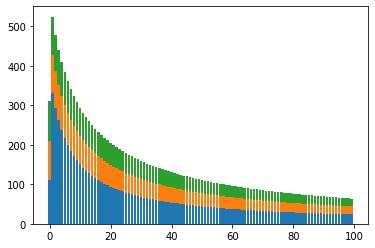

In [11]:
# Gut population stacked bar chart
# this one is pretty expensive chart, run it only with small datasets.

X = np.arange(gutPopHistory.shape[0])
plt.bar(X,gutPopHistory[:,0])
plt.bar(X,gutPopHistory[:,1],bottom = gutPopHistory[:,0])
plt.bar(X,gutPopHistory[:,2],bottom = np.sum(gutPopHistory[:,:2],axis = 1))




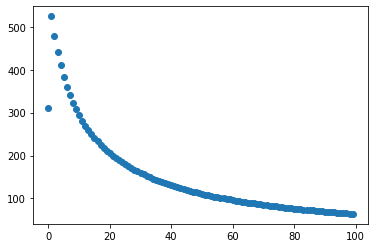

In [42]:
# this is for the total gut population, just to get an estimate of the overall abundance of the bacterium population.

plt.scatter(X, np.sum(gutPopHistory,axis = 1))


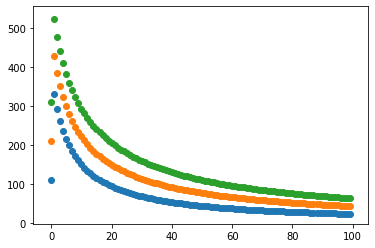

In [12]:
# stacked scatter plots for each bacterium population
# is not much relevant or revealing.
#  
X = np.arange(gutPopHistory.shape[0])
plt.scatter(X,gutPopHistory[:,0])
plt.scatter(X,np.sum(gutPopHistory[:,:2],axis = 1))
plt.scatter(X, np.sum(gutPopHistory,axis = 1))


### this is totally weird, after limiting the growth constant with the nutrient available (behavioral output), all populations are dying out quickly. Bacterium 1 (associated with the dopamine linked nutrient) reaches a peak and then dies thereafter. Why, I have no clue. 

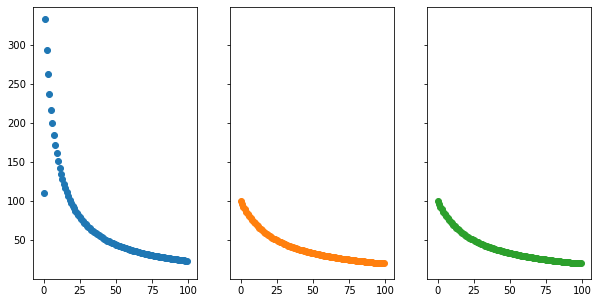

In [40]:
# one scatter plot for each bacterium population. 
# relevant to trace out the population evolution across timesteps.


X = np.arange(gutPopHistory.shape[0])
fig,(ax1,ax2,ax3) = plt.subplots(1,3,sharex = True, sharey = True,figsize = (10,5))
cm = plt.get_cmap("tab10")
n = 1000
ax1.scatter(X[:n],gutPopHistory[:n,0],color = cm(0))
ax2.scatter(X[:n],gutPopHistory[:n,1],color = cm(1))
ax3.scatter(X[:n],gutPopHistory[:n,2],color = cm(2))


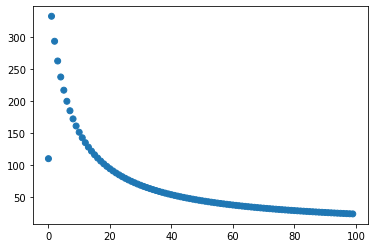

In [43]:
# plotted the maximum of the three gut bacterial populations at each timestep

cm1 = np.random.random((3,3))
cm2 = plt.rcParams['axes.prop_cycle'].by_key()['color']
cm = plt.get_cmap("tab10")

a = np.argmax(gutPopHistory,axis = 1)
b = np.max(gutPopHistory,axis = 1)
plt.scatter(range(len(a)),b,c = cm(a))


### no idea, why Q table always always look like this. right bottom has the max q value and left botton is never touched. vice versa for the bottom states.
probably something to do with the way we are calculating the actions and applying probabilities on the states and clipping at the edges.. 

Text(0, 0.5, 'states')

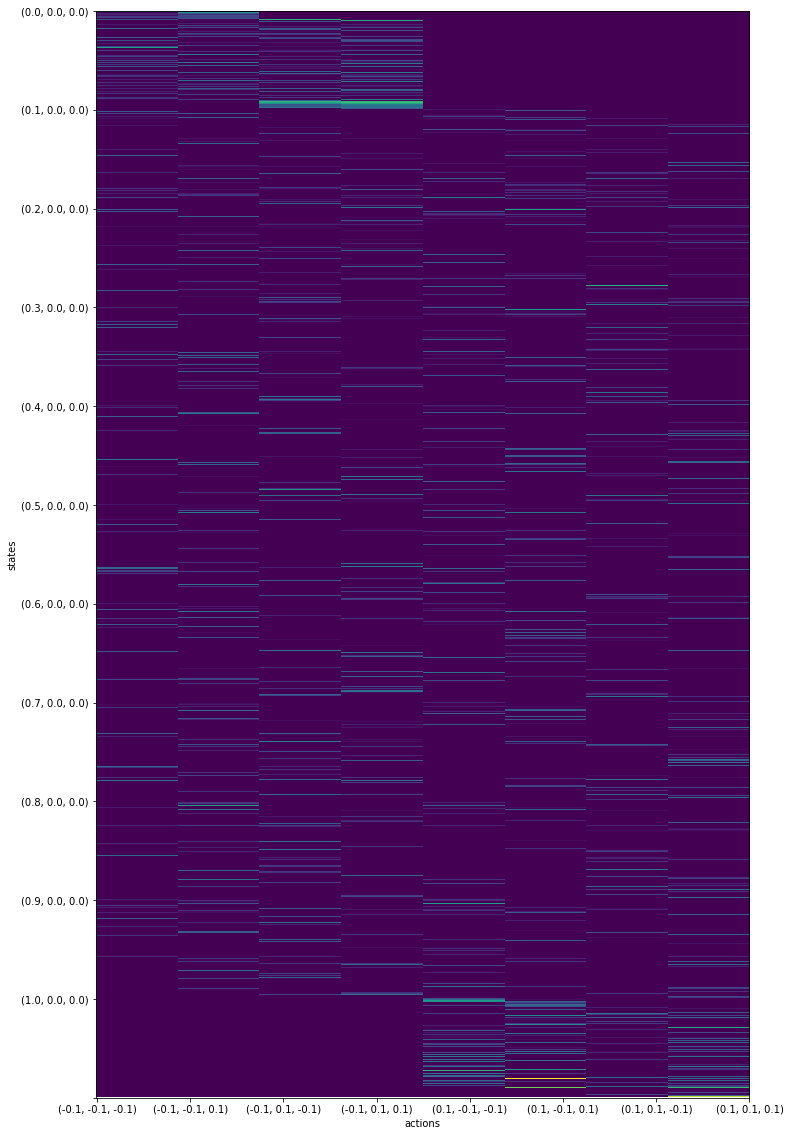

In [14]:
# Qtable heat map


actions = ['a'+str(i) for i in range(1,9)]

actions = behavior.actionSet
states = [behavior.stateSet[int(i)] for i in np.linspace(0,len(behavior.stateSet),behavior.stateSlicer+1)[:-1]]

fig,ax = plt.subplots(1,1,figsize = (20,20))
ax.imshow(np.repeat(brain.qTable,100,1))

ax.set_xticks(np.linspace(1,800,len(actions)))
ax.set_xticklabels(actions)
ax.set_yticks(np.linspace(0,len(behavior.stateSet),behavior.stateSlicer+1))
ax.set_yticklabels(states)
ax.set_xlabel("actions")
ax.set_ylabel("states")

### this behavior history looks weird because if only bacterium 1 is releasing dopamine, then craving for this nutrient alone shud increase. Here nutrient 1 ingestion towards the end has died down.
#  

Text(0.45, 0.3, 'time steps ----->')

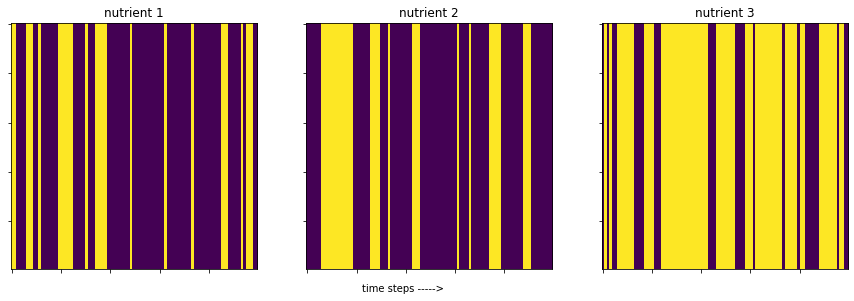

In [37]:
# Behavior history for each bacterium - whether the bacteria received the nutrient or not. 
# yellow represents higher values (or presence od nutrient to the bacteria)

import numpy as np
# a = np.random.choice([0,1],(20000,3))
a = behaviorHistory
fig,(ax1,ax2,ax3) = plt.subplots(1,3,sharey = True,sharex = True,figsize = (15,10))
ax1.imshow(np.tile(a[:,0],(stepSize,1)))
ax2.imshow(np.tile(a[:,1],(stepSize,1)))
ax3.imshow(np.tile(a[:,2],(stepSize,1)))
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax1.set_title("nutrient 1")
ax2.set_title("nutrient 2")
ax3.set_title("nutrient 3")
plt.subplots_adjust(wspace=None, hspace=None)
fig.text(0.45,0.3,"time steps ----->")


In [ ]:
# Logistic Growth

n = 50
gc = 0.2
dc = 0.2
nHistory = [n]
inputNutrient = 0
# prob = 0.1
for t in range(10000):
#     prob = prob + 1/10000
#     if(prob < 0):
#         prob = 0
#     if(prob > 1):
#         prob = 1
    inputNutrient = np.random.binomial(1, 0.5)
    n = n + n*gc*inputNutrient - n*n*dc/2500
    nHistory.append(n)
plt.plot(nHistory)

In [ ]:
plt.plot(nHistory)
plt.yscale("log")

In [45]:
# checking population evolution standalone in a function.

pop = np.ones((3))*100
gc = 0.2
dc = 0.2
K = 10000
nutPopMap= np.random.choice([0,1],3)
print(nutPopMap)
print(pop)

for i in range(100):
    pop*(1+gc*np.array([1,0,0]) - pop*dc/K)

[0 0 0]
[100. 100. 100.]


array([119.8,  99.8,  99.8])

In [ ]:
a = np.array(stateHistory)
states, count = np.unique(a, axis = 0, return_counts = True)
print(states[np.argsort(count)[::-1]])
print(count)